In [1]:
import numpy as np
from typing import Any, Dict, List, Optional, Sequence, Tuple
from ssri_interactions.transforms.spikes import SpikesHandler
from ssri_interactions.io import load_derived_generic
from ssri_interactions.config import Config, ExperimentInfo
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(context="paper", style="ticks")

In [3]:
class SpikeTrainLoader:
    def __init__(
        self,
        session_name: str,
        duration: float = 5.0,
        max_neurons: Optional[int] = None,
        block="pre",
    ):
        self.session_name = session_name
        self.duration = duration
        self.block = block
        neurons = load_derived_generic("neuron_types.csv").loc[
            lambda x: x["session_name"] == session_name
        ]
        self.max_neurons = max_neurons
        self.neurons = neurons

    def get_trians_by_type(self, t_start) -> Dict[str, List[np.ndarray]]:
        types = self.neurons.neuron_type.unique()
        trains = {}
        for neuron_type in types:
            neurons = self.neurons.loc[lambda x: x["neuron_type"] == neuron_type][
                "neuron_id"
            ].values
            trains[neuron_type] = self.get_trains(t_start, ids=neurons)
        return trains

    def get_trains(self, t_start, ids: Optional[Sequence] = None) -> List[np.ndarray]:
        if ids is None:
            ids = self.neurons["neuron_id"].values

        sh = SpikesHandler(
            bin_width=1,
            session_names=[self.session_name],
            t_start=t_start,
            t_stop=t_start + self.duration,
            block=self.block,
        )
        df_spikes = sh.spikes.loc[lambda x: x["neuron_id"].isin(ids)]
        trains = [dfg["spiketimes"].values for _, dfg in df_spikes.groupby("neuron_id")]
        trains = trains[: self.max_neurons]
        return trains


def make_grid(
    trains: Dict[Any, str],
    fig: Optional[plt.Figure] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order=None,
):
    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    n_rows = len(neuron_types)
    n_cols = 1
    height_ratios = np.array([len(trains[neuron_type]) for neuron_type in neuron_types])
    height_ratios = height_ratios / height_ratios.sum()
    gridspec_kw = gridspec_kw or {}
    gridspec_kw["height_ratios"] = height_ratios
    axes = fig.subplots(n_rows, n_cols, gridspec_kw=gridspec_kw)
    return axes


def plot_raster(trains: List[np.ndarray], ax=None, **eventplot_kwargs):
    ax = ax or plt.subplots()[1]
    ax.eventplot(
        trains,
        **eventplot_kwargs,
    )
    ax.axis("off")
    return ax


def plot_raster_grouped(
    trains: Dict[str, List[np.ndarray]],
    fig=None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    eventplot_kwargs = eventplot_kwargs or {}
    gridspec_kw = gridspec_kw or {}

    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    axes = make_grid(trains, fig=fig, gridspec_kw=gridspec_kw, type_order=neuron_types)

    for ax, neuron_type in zip(axes, neuron_types):
        train_list = trains[neuron_type]
        plot_raster(train_list, ax=ax, **eventplot_kwargs)
    return fig, axes


def plot_raster_grouped_time(
    trains: List[Dict[str, List[np.ndarray]]],
    fig: plt.Figure = None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    fig = fig or plt.figure()

    num_timepoints = len(trains)
    sub_figs = fig.subfigures(1, num_timepoints)

    for sub_fig, train in zip(sub_figs, trains):
        plot_raster_grouped(
            train,
            fig=sub_fig,
            eventplot_kwargs=eventplot_kwargs,
            gridspec_kw=gridspec_kw,
            type_order=type_order,
        )
    return fig

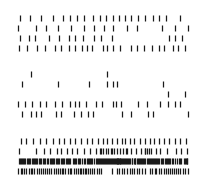

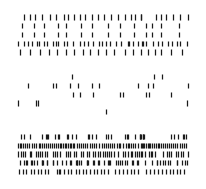

In [17]:
dd = Config.fig_dir / "spiketrain_props"
dd.mkdir(exist_ok=True, parents=True)


sal_session = ExperimentInfo.sal_sessions[3]
cit_session = ExperimentInfo.cit_sessions[0]

t_start = 1230
duration = 5
max_neurons = 5

loader_sal = SpikeTrainLoader(sal_session, duration=duration, max_neurons=max_neurons)
loader_cit = SpikeTrainLoader(cit_session, duration=duration, max_neurons=max_neurons)

trains_sal = loader_sal.get_trians_by_type(t_start=t_start)
trains_cit = loader_cit.get_trians_by_type(t_start=t_start)


f_cit = plt.figure(figsize=(2.4, 2.2))
f_sal = plt.figure(figsize=(2.4, 2.2))


plot_raster_grouped(
    fig=f_sal,
    trains=trains_sal,
    type_order=["SR", "SIR", "FF"],
    eventplot_kwargs={"color": "k", "linewidths": 0.9, "linelengths": 0.6},
)
f_sal.savefig(dd / "sal_raster.png", bbox_inches="tight", dpi=300)

plot_raster_grouped(
    fig=f_cit,
    trains=trains_cit,
    type_order=["SR", "SIR", "FF"],
    eventplot_kwargs={"color": "k", "linewidths": 0.9, "linelengths": 0.6},
)
f_cit.savefig(dd / "cit_raster.png", bbox_inches="tight", dpi=300)

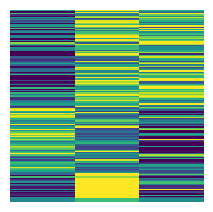

In [20]:
from sklearn.preprocessing import scale, robust_scale, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

cols = ["cv_isi_burst", "mean_firing_rate", "width_basepost"]
neuron_types = load_derived_generic("neuron_types.csv").sort_values("neuron_type", ascending=False)
pipe = make_pipeline(KNNImputer(), RobustScaler())

scaled = pipe.fit_transform(neuron_types[cols])

scaled_sal = scaled[neuron_types["group"] == "SAL"]
scaled_cit = scaled[neuron_types["group"] == "CIT"]

f_sal = plt.figure(figsize=(2.5, 2.5))
ax_sal = f_sal.subplots()
sns.heatmap(scaled_sal, ax=ax_sal, cmap="viridis", cbar=False, xticklabels=cols, vmin=-1, vmax=1, robust=True)
ax_sal.set_yticks([])
ax_sal.set_xticks([])

f_sal.savefig(dd / "sal_heatmap.png", bbox_inches="tight", dpi=300)

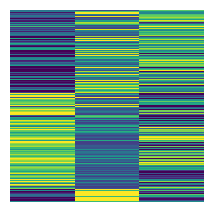

In [21]:
f_cit = plt.figure(figsize=(2.5, 2.5))
ax_cit = f_cit.subplots()
sns.heatmap(scaled_cit, ax=ax_cit, cmap="viridis", cbar=False, xticklabels=cols, vmin=-1, vmax=1, robust=True)
ax_cit.set_yticks([])
ax_cit.set_xticks([])
f_cit.savefig(dd / "cit_heatmap.png", bbox_inches="tight", dpi=300)